# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import holidays

/home/arejula27/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

This is a future version incompatibility warning from Holidays v0.63
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projects,
we highly recommend pinning the version of our API that you rely on. You can pin your current
holidays v0.x dependency (e.g., holidays==0.63) or limit it (e.g., holidays<1.0

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
if not os.environ.get("HOPSWORKS_API_KEY"):
    with open('../../data/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="juls_first_project")
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()


BICING_API_KEY = secrets.get_secret("BICING_API_KEY").value
station_str = secrets.get_secret("STATION_PARAMS_JSON").value
station= json.loads(station_str)

city=station['city']
station_id=station['station_id']
bikes_url=station['bikes_url']
latitude=station['latitude']
longitude=station['longitude']

today = datetime.date.today()

2025-01-04 12:29:00,830 INFO: Initializing external client
2025-01-04 12:29:00,831 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-04 12:29:02,359 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164440


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
feature_view = fs.get_feature_view(
    name='bikes_fv',
    version=2,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bikes_xgboost_model",
    version=2,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0179098E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['i', 'i', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [76]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
yesterday = today - datetime.timedelta(days=1)
# get the newest row
now = datetime.datetime.now()
batch_data = weather_fg.filter(weather_fg.date >= yesterday and weather_fg.date <= today).read()

#order by date
batch_data = batch_data.sort_values(by='date', ascending=False)
batch_data= batch_data.head(1)
batch_data



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 


,date,precipitation,temperature,city,time,day
2262,2025-01-04 01:00:00+00:00,0.0,6.3,Barcelona,1,2025-01-04


In [77]:
## Adding a new boolean column if the date is weekend or not
batch_data['is_weekend'] = today.weekday() > 4
## Adding a new boolean column if the date is holiday or not
holidays_es = holidays.Spain()
#check if the today is holiday
batch_data['is_holiday'] = today in holidays_es

batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday
2262,2025-01-04 01:00:00+00:00,0.0,6.3,Barcelona,1,2025-01-04,True,False


In [78]:
bikes_fg = fs.get_feature_group(
    name='bikes',
    version=1,
)

# get the newest row, instead of downloading all the data get only the one since yesterday
yesterday = today - datetime.timedelta(days=1)
bikes_data = bikes_fg.filter(bikes_fg.date >= yesterday).read()
bikes_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,day,time,num_bikes_available,date,is_weekend,is_holiday,prev_num_bikes_available
0,2025-01-04,11,11.0,2025-01-04 11:00:00+00:00,True,False,19.25


In [79]:
prev_bikes = bikes_data[bikes_data['date'] == bikes_data['date'].max()]["num_bikes_available"]
batch_data["prev_num_bikes_available"] =prev_bikes[0]
batch_data



,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available
2262,2025-01-04 01:00:00+00:00,0.0,6.3,Barcelona,1,2025-01-04,True,False,11.0


In [80]:
now = datetime.datetime.now()
batch_data["date"] = now
batch_data["time"] = now.hour
batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available
2262,2025-01-04 12:56:22.074263,0.0,6.3,Barcelona,12,2025-01-04,True,False,11.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [82]:
batch_data['predicted_num_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['is_weekend', 'is_holiday', 'prev_num_bikes_available', 'precipitation', 'temperature', 'time']])
batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available,predicted_num_bikes_available
2262,2025-01-04 12:56:22.074263,0.0,6.3,Barcelona,12,2025-01-04,True,False,11.0,13.380713


In [83]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 2262 to 2262
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           1 non-null      datetime64[us]
 1   precipitation                  1 non-null      float32       
 2   temperature                    1 non-null      float32       
 3   city                           1 non-null      object        
 4   time                           1 non-null      int64         
 5   day                            1 non-null      object        
 6   is_weekend                     1 non-null      bool          
 7   is_holiday                     1 non-null      bool          
 8   prev_num_bikes_available       1 non-null      float64       
 9   predicted_num_bikes_available  1 non-null      float32       
dtypes: bool(2), datetime64[us](1), float32(3), float64(1), int64(1), object(2)
memory usage: 

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

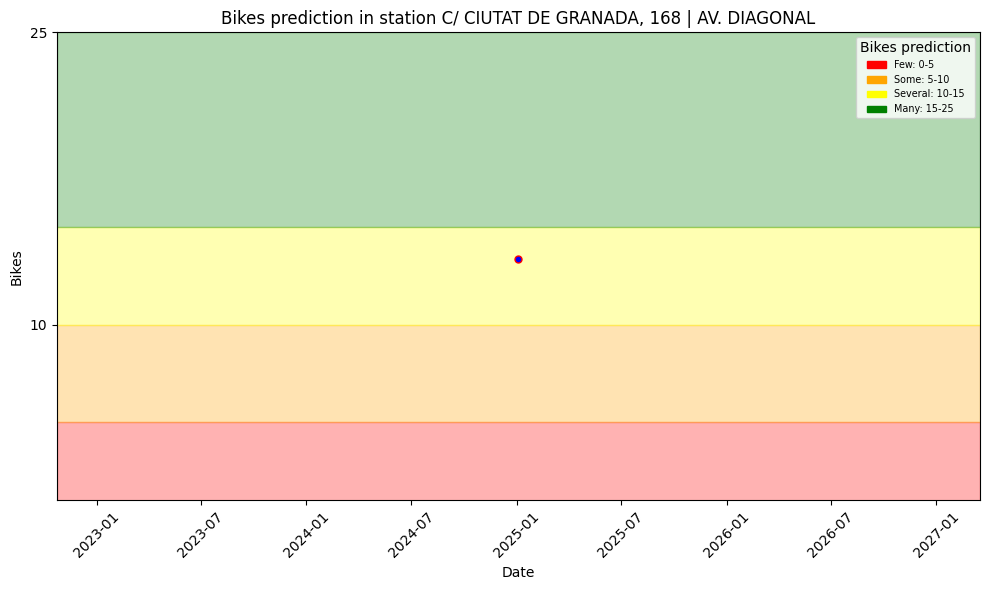

In [85]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
# rename predicted_num_bikes_available to num_bikes_available
batch_data.rename(columns={'predicted_num_bikes_available': 'num_bikes_available'}, inplace=True)
plt = util.plot_bikes_prediction(batch_data, file_path) 
plt.show()

In [87]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bikes_predictions',
    description='Bikes availability prediction monitoring',
    version=1,
    primary_key=['date'],
    event_time="date"
)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

2024-06-13 18:13:39,897 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/905563


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fccff103490>, None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-06-21 00:00:00+00:00,21.049999,0.0,11.620809,286.18927,stockholm,18.89632,stockholm-hornsgatan-108,sweden,1


In [16]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


,date,pm25,country,city,street,url
0,2019-03-31 00:00:00+00:00,31.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
1,2019-05-12 00:00:00+00:00,30.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2,2020-07-17 00:00:00+00:00,16.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
3,2020-10-21 00:00:00+00:00,50.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
4,2019-02-03 00:00:00+00:00,29.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
...,...,...,...,...,...,...
2363,2021-12-03 00:00:00+00:00,25.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2364,2024-01-25 00:00:00+00:00,9.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2365,2018-11-18 00:00:00+00:00,37.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2366,2019-10-20 00:00:00+00:00,30.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.84s) 
2024-06-13 18:15:11,028 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-06-13 00:00:00+00:00,14.65,0.6,13.70839,209.931427,stockholm,21.226244,15.0,stockholm-hornsgatan-108,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

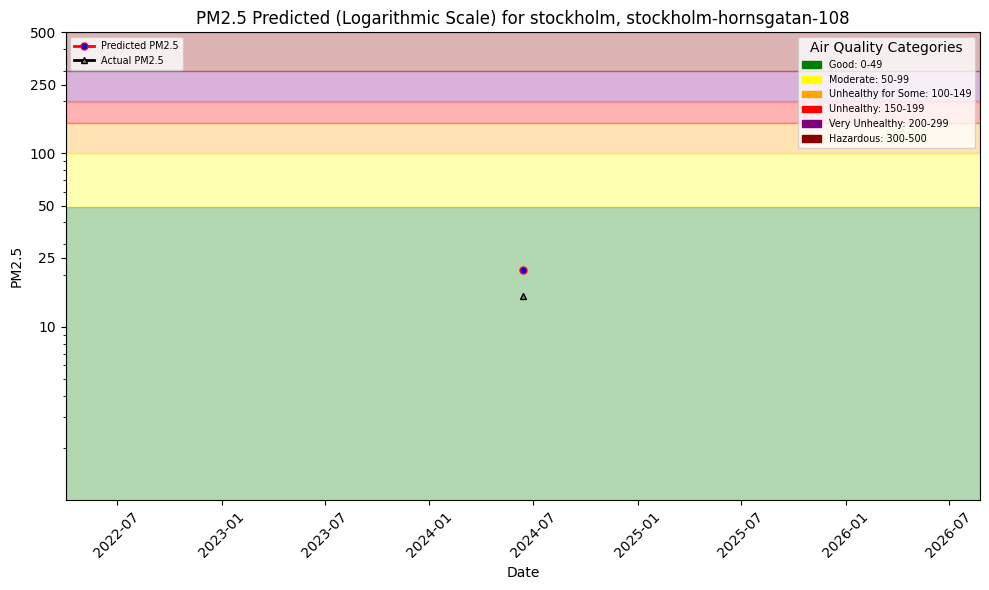

In [18]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---